Current working directory: /voc/work/CapStone project
Outliers detected in `item_count`: 1975 rows.


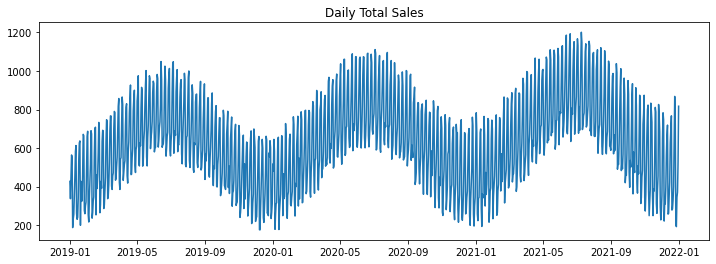

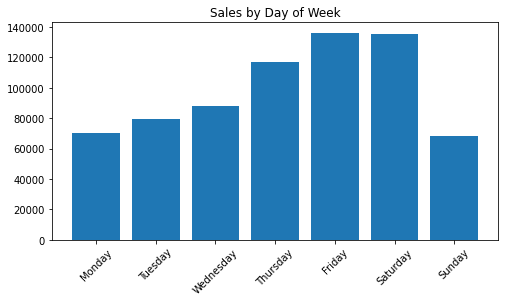

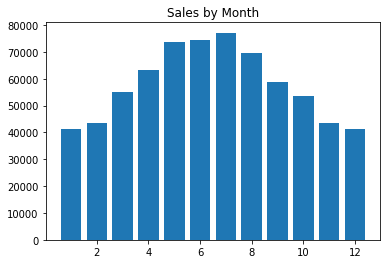

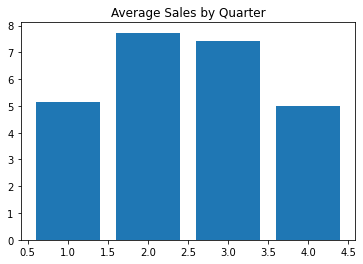

Sales by store and year:
 year                2019      2020      2021
store_name                                  
Beachfront Bar     439.0     437.0     429.0
Bob's Diner     211799.0  230191.0  245537.0
Corner Cafe        423.0     415.0     472.0
Fou Cher           392.0     357.0     357.0
Surfs Up           594.0     627.0     582.0
Sweet Shack        590.0     554.0     592.0
[DEBUG] Columns available: ['date', 'item_id', 'item_count', 'store_id', 'item_name', 'kcal', 'store_name', 'price', 'year', 'month', 'day', 'day_of_week', 'quarter', 'count_zscore']
Top 10 items overall:
 item_name
Strawberry Smoothy                 236337.0
Frozen Milky Smoothy               103263.0
Amazing pork lunch                  61043.0
Mutton Dinner                       52772.0
Orange Juice                        43874.0
Blue Ribbon Beef Entree             42774.0
Amazing Steak Dinner with Rolls     34439.0
Sweet Frozen Soft Drink             27490.0
Sea Bass with Vegetables Dinner     23839.0
Sw

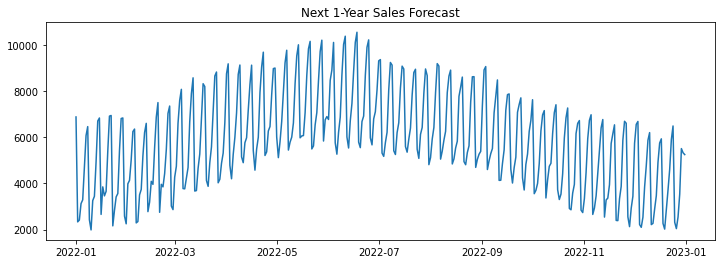

Epoch 1/20
22/22 [==============================] - 1s 10ms/step - loss: 0.1908
Epoch 2/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0431
Epoch 3/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0370
Epoch 4/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0357
Epoch 5/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0350
Epoch 6/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0320
Epoch 7/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0345
Epoch 8/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0339
Epoch 9/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0320
Epoch 10/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0321
Epoch 11/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0313
Epoch 12/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0333
Epoch 13/20
22/22 [===========================

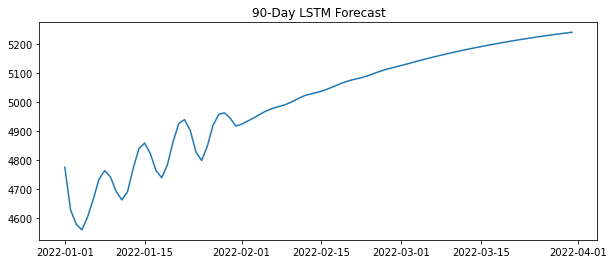

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# print current working directory for verification
print("Current working directory:", os.getcwd()) # nothing just to check directory location
DATA_DIR = "."

# In the lms restaurants.csv is wrongly spelled as resturants just to let you know guys
# Utility to find restaurant CSV
def find_restaurant_file():
    """Find either 'restaurants.csv' or a similarly named typo."""
    candidates = [f for f in os.listdir(DATA_DIR) if "restaur" in f.lower()]
    if not candidates:
        raise FileNotFoundError(f"No restaurant CSV found in {DATA_DIR}. Make sure 'restaurants.csv' is present.")
    # Prefer correctly spelled
    for name in candidates:
        if name.lower() == "restaurants.csv":
            return name
    return candidates[0]


# Load and merge data
def load_and_merge_data():
    sales_file = os.path.join(DATA_DIR, "sales.csv")
    items_file = os.path.join(DATA_DIR, "items.csv")
    rest_file  = find_restaurant_file()
    rest_path  = os.path.join(DATA_DIR, rest_file)

    sales       = pd.read_csv(sales_file, parse_dates=["date"])
    items       = pd.read_csv(items_file)
    restaurants = pd.read_csv(rest_path)

    # Normalize column names
    sales.columns       = sales.columns.str.lower()
    items.columns       = items.columns.str.lower()
    restaurants.columns = restaurants.columns.str.lower()

    # Rename for consistency
    items       = items.rename(columns={"id": "item_id", "name": "item_name", "cost": "price"})
    restaurants = restaurants.rename(columns={"id": "store_id", "name": "store_name"})
    if "item" in sales.columns and "item_id" not in sales.columns:
        sales = sales.rename(columns={"item": "item_id"})

    # Merge datasets
    df = (
        sales
        .merge(items,       on="item_id",  how="left")
        .merge(restaurants, on="store_id", how="left")
    )

    # Consolidate price column
    if "price_y" in df.columns:
        df["price"] = df["price_y"]
    elif "price_x" in df.columns:
        df["price"] = df["price_x"]
    elif "price" in df.columns:
        df["price"] = df["price"]
    else:
        raise KeyError("No price column found after merge.")
    for c in ["price_x", "price_y"]:
        if c in df.columns:
            df.drop(columns=c, inplace=True)

    # Feature engineering
    df["year"]        = df["date"].dt.year
    df["month"]       = df["date"].dt.month
    df["day"]         = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.day_name()
    df["quarter"]     = df["date"].dt.quarter

    return df


def detect_outliers(df):
    from scipy import stats
    df["count_zscore"] = np.abs(stats.zscore(df["item_count"]))
    outliers = df[df["count_zscore"] > 3]
    print(f"Outliers detected in `item_count`: {len(outliers)} rows.")
    return outliers


def eda(df):
    # a) Daily total sales
    daily = df.groupby("date")["item_count"].sum().reset_index()
    plt.figure(figsize=(12, 4))
    plt.plot(daily["date"], daily["item_count"])
    plt.title("Daily Total Sales")
    plt.show()

    # b) By day of week
    dow = (
        df.groupby("day_of_week")
          .item_count.sum()
          .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    )
    plt.figure(figsize=(8, 4))
    plt.bar(dow.index, dow.values)
    plt.title("Sales by Day of Week")
    plt.xticks(rotation=45)
    plt.show()

    # c) By month
    monthly = df.groupby("month").item_count.sum()
    plt.figure(figsize=(6, 4))
    plt.bar(monthly.index, monthly.values)
    plt.title("Sales by Month")
    plt.show()

    # d) Average by quarter
    q = df.groupby("quarter").item_count.mean()
    plt.figure(figsize=(6, 4))
    plt.bar(q.index, q.values)
    plt.title("Average Sales by Quarter")
    plt.show()

    # e) Year-over-year by store
    rest_year = df.groupby(["store_name","year"]).item_count.sum().unstack().fillna(0)
    print("Sales by store and year:\n", rest_year)


def data_insights(df):
    print("[DEBUG] Columns available:", df.columns.tolist())
    if "price" not in df.columns:
        raise KeyError("No 'price' column found in your merged DataFrame.")

    top_items = df.groupby("item_name").item_count.sum().nlargest(10)
    print("Top 10 items overall:\n", top_items)

    pop = df.groupby(["store_name","item_name"]).item_count.sum().reset_index()
    idx = pop.groupby("store_name").item_count.idxmax()
    print("Most popular item per store:\n", pop.loc[idx])

    df["revenue"] = df["price"] * df["item_count"]
    daily_rev     = df.groupby(["store_name","date"]).revenue.sum().reset_index()
    avg_rev       = daily_rev.groupby("store_name").revenue.mean()
    total_ct      = df.groupby("store_name").item_count.sum()
    print("Store with highest volume:", total_ct.idxmax())
    print("Store avg daily revenue:\n", avg_rev.sort_values(ascending=False))

    exp = df.groupby(["store_name","item_name"])["price"].max().reset_index()
    idx2 = exp.groupby("store_name")["price"].idxmax()
    result = exp.loc[idx2]
    if "kcal" in df.columns:
        kcal_df = df[["item_name","kcal"]].drop_duplicates()
        result = result.merge(kcal_df, on="item_name", how="left")
    print("Most expensive item per store with kcal (if available):\n", result)


def ml_forecasting(df):
    df2 = df.copy()
    df2["sales"] = df2["price"] * df2["item_count"]
    daily = df2.groupby("date").sales.sum().reset_index()

    daily["dow"]     = daily["date"].dt.dayofweek
    daily["month"]   = daily["date"].dt.month
    daily["quarter"] = daily["date"].dt.quarter
    daily["day"]     = daily["date"].dt.day

    cutoff = daily["date"].max() - pd.DateOffset(months=6)
    train  = daily[daily["date"] <= cutoff]
    test   = daily[daily["date"] >  cutoff]
    X_cols = ["dow","month","quarter","day"]
    X_train, y_train = train[X_cols], train["sales"]
    X_test,  y_test  = test[X_cols],  test["sales"]

    models = {"LR": LinearRegression(),
              "RF": RandomForestRegressor(n_estimators=100, random_state=42),
              "XG": xgb.XGBRegressor(n_estimators=100, random_state=42)}
    preds = {}
    for name, mdl in models.items():
        mdl.fit(X_train, y_train)
        p = mdl.predict(X_test)
        preds[name] = p
        rmse = np.sqrt(mean_squared_error(y_test, p))
        print(f"{name} RMSE = {rmse:.2f}")

    best = min(preds, key=lambda k: np.sqrt(mean_squared_error(y_test, preds[k])))
    print("✅ Best model:", best)
    model = models[best]

    future = pd.DataFrame({"date": pd.date_range(
        start=daily["date"].max() + pd.Timedelta(days=1), periods=365)})
    for col in ["dow","month","quarter","day"]:
        future[col] = getattr(future["date"].dt, col if col!="dow" else "dayofweek")
    future["forecast"] = model.predict(future[X_cols])

    plt.figure(figsize=(12, 4))
    plt.plot(future["date"], future["forecast"])
    plt.title("Next 1-Year Sales Forecast")
    plt.show()


def lstm_forecasting(df):
    df2 = df.copy()
    df2["sales"] = df2["price"] * df2["item_count"]
    series = df2.groupby("date").sales.sum()

    split = series.index.max() - pd.DateOffset(months=12)
    train_s, test_s = series[:split], series[split:]

    from sklearn.preprocessing import MinMaxScaler
    scaler   = MinMaxScaler()
    train_ts = scaler.fit_transform(train_s.values.reshape(-1,1))
    test_ts  = scaler.transform(test_s.values.reshape(-1,1))

    n_input, n_feat = 30, 1
    gen = TimeseriesGenerator(train_ts, train_ts, length=n_input, batch_size=32)

    model = Sequential([
        LSTM(50, activation="relu", input_shape=(n_input, n_feat)),
        Dropout(0.2),
        Dense(1),
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(gen, epochs=20, verbose=1)

    preds, batch = [], train_ts[-n_input:].reshape((1,n_input,n_feat))
    for _ in range(len(test_ts)):
        p     = model.predict(batch)[0]
        preds.append(p)
        batch = np.append(batch[:,1:,:], [[p]], axis=1)
    preds = scaler.inverse_transform(preds)
    mape  = mean_absolute_percentage_error(test_s.values, preds)
    print(f"LSTM Test MAPE = {mape:.2%}")

    full_ts  = scaler.fit_transform(series.values.reshape(-1,1))
    full_gen = TimeseriesGenerator(full_ts, full_ts, length=n_input, batch_size=32)
    model.fit(full_gen, epochs=10, verbose=1)

    fut, batch = [], full_ts[-n_input:].reshape((1,n_input,n_feat))
    for _ in range(90):
        p     = model.predict(batch)[0]
        fut.append(p)
        batch = np.append(batch[:,1:,:], [[p]], axis=1)
    fut = scaler.inverse_transform(fut)
    fut_dates = pd.date_range(start=series.index.max()+pd.Timedelta(days=1), periods=90)

    plt.figure(figsize=(10, 4))
    plt.plot(fut_dates, fut)
    plt.title("90-Day LSTM Forecast")
    plt.show()


if __name__ == "__main__":
    df = load_and_merge_data()
    detect_outliers(df)
    eda(df)
    data_insights(df)
    ml_forecasting(df)
    lstm_forecasting(df)
